In [ ]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import zarr


#  Find the list of variables
##  1.  Get a full list of variables in the hourly data

In [ ]:
one_hourly_file = '/tmpdata/i.e215.I2000Clm50SpGs.hw_production.02/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1986-01-01-00000.nc'
ds_hourly = xr.open_dataset(one_hourly_file)
ds_hourly

In [ ]:
ds_hourly_vars = list(ds_hourly.data_vars)
ds_hourly_vars

##  2.  Define the core daily variables for UHI analysis

In [ ]:
core_vars = ['TSA', 'TSA_R', 'TSA_U', 'WBA', 'WBA_R', 'WBA_U']
# find all vars in ds_hourly_vars that has 3 dimension and are not in core_vars

other_vars = [var for var in ds_hourly_vars if var not in core_vars]
other_vars


In [ ]:
#3  find variables that are not in core_vars and are 3D
other_vars_3D = [var for var in other_vars if len(ds_hourly[var].dims) == 3]
ds_hourly[other_vars_3D]

In [ ]:
dims = ds_hourly.dims.keys()
dims

In [ ]:
new_chunksizes = (1080, 90, 90)
new_chunksizes_dict = dict(zip(dims, new_chunksizes))
new_chunksizes_dict

In [26]:
def generate_noleap_date_range(start_date, end_date):
    """Generate a date range for a 'noleap' calendar."""
    current_date = start_date
    date_list = []
    while current_date <= end_date:
        date_list.append(current_date)
        next_day = current_date + pd.Timedelta(days=1)
        if next_day.month == 2 and next_day.day == 29:
            next_day += pd.Timedelta(days=1)
        current_date = next_day
    return date_list

netcdf_dir = '/tmpdata/i.e215.I2000Clm50SpGs.hw_production.02/'
zarr_path = '/tmpdata/zarr/i.e215.I2000Clm50SpGs.hw_production.02'

start_date = pd.to_datetime('1986-01-01')
end_date = pd.to_datetime('1986-12-31')
date_range = generate_noleap_date_range(start_date, end_date)
netcdf_filenames = [
    os.path.join(netcdf_dir, f"i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.{date.strftime('%Y-%m-%d')}-00000.nc")
    for date in date_range]

core_vars = ['TSA', 'TSA_R', 'TSA_U', 'WBA', 'WBA_R', 'WBA_U']
# Example to fetch other variables, adjust as per your data
one_hourly_file = '/tmpdata/i.e215.I2000Clm50SpGs.hw_production.02/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1986-04-01-00000.nc'
ds_hourly = xr.open_dataset(one_hourly_file)
other_vars = [var for var in ds_hourly.data_vars if (var not in core_vars and len(ds_hourly[var].dims) == 3)]

In [ ]:
ds_hourly.chunk({'time': 12, 'lat': 192, 'lon': 288})

In [ ]:
ds_hourly

In [20]:
def set_unwanted_to_nan(ds):
    # Condition for JJA in the Northern Hemisphere
    condition_jja_nh = (ds['time.season'] == 'JJA') & (ds['lat'] >= 0)

    # Condition for DJF in the Southern Hemisphere
    condition_djf_sh = (ds['time.season'] == 'DJF') & (ds['lat'] < 0)

    # Combine conditions for the desired data, set others to NaN
    condition = condition_jja_nh | condition_djf_sh

    # Apply condition, keeping structure intact
    ds_filtered = ds.where(condition)

    return ds_filtered


In [27]:
ds_hourly_filtered = set_unwanted_to_nan(ds_hourly)
ds_hourly_filtered

<xarray.Dataset>
Dimensions:        (time: 24, lat: 192, hist_interval: 2, lon: 288,
                    levgrnd: 25, levlak: 10, levdcmp: 1)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) object 1986-04-01 00:00:00 ... 1986-04-01 23:00:00....
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/65)
    mcdate         (time, lat) float64 nan nan nan nan nan ... nan nan nan nan
    mcsec          (time, lat) float64 nan nan nan nan nan ... nan nan nan nan
    mdcur          (time, lat) float64 nan nan nan nan nan ... nan nan nan nan
    mscur          (time, lat) float64 nan nan nan nan nan ... nan nan nan nan
    nstep          (time, lat) float64 nan nan nan nan nan ... nan nan nan nan
    time_bounds    (time, hist_interval, lat) object nan nan nan ... nan nan nan
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WASTEHEAT      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WBA            (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WBA_R          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WBA_U          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    WIND           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 23:27:33
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          hour_1
    Time_constant_3Dvars_filename:             ./i.e215.I2000Clm50SpGs.hw_pro...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

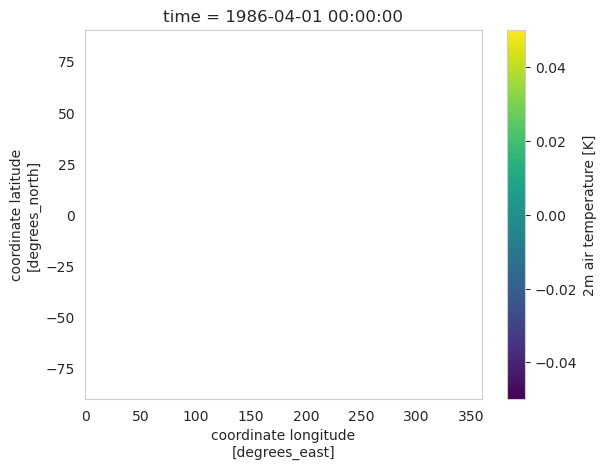

In [28]:
ds_hourly_filtered['TSA'].isel(time=0).plot()